In [32]:
# dependecies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import random
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

PREPROCESSING/EDA

In [33]:
# reading in the data
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [34]:
# understanding categorical vs numerical (can also use df.dtypes)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [35]:
# checking null values
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [36]:
# checking duplicated values
data.duplicated().sum()

np.int64(1)

In [37]:
duplicated_rows = data[data.duplicated()]
duplicated_rows

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [38]:
# handling duplicates
data = data.drop_duplicates()

In [39]:
data.shape

(1337, 7)

don't do label encoding which is assigning a number to each feature; it messes up a neural network; changing to one hot encoding which makes dummy variables for each feature (sql distinct comes in clutch here) and then uses binary

In [40]:
ohe_region = pd.get_dummies(data.region)
ohe_sex = pd.get_dummies(data.sex)
ohe_smoker = pd.get_dummies(data.smoker)

ADVANCED FEATURE ENGINEERING

In [41]:
# numerical => categorical for "imbalance"/skew purposes; THIS IS CALLED BINNING
data['age_category'] = pd.cut(data['age'], bins=[0, 25, 35, 45, 55, 65], labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
data['bmi_category'] = pd.cut(data['bmi'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])
data['charges_category'] = pd.cut(data['charges'], bins=[0, 10000, 20000, 30000, 40000, 50000, 60000, np.inf], labels=['$0-10,000', '$10,001-20,000', '$20,001-30,000', '$30,001-40,000', '$40,001-50,000', '$50,001-60,000', '$60,000+'])

In [42]:
# focusing on smokers as correlation matrix indicated strong relationship
data['elderly_smoker'] = ((data['smoker'] == 'yes') & (data['age'] > 39)).astype(int)
data['obese_smoker'] = ((data['smoker'] == 'yes') & (data['bmi_category'] == 'Obese')).astype(int)

# family size impact (testing)
data['has_children'] = ((data['children'] > 0)).astype(int)
data['largeFamily'] = ((data['children'] >= 3)).astype(int)

# MORE
data['age_squared'] = data['age'] ** 2
data['log_bmi'] = np.log1p(data['bmi'])
data['log_charges'] = np.log1p(data['charges'])

In [43]:
data = pd.concat([data, ohe_region, ohe_sex, ohe_smoker], axis='columns')
data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category,charges_category,...,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,19,female,27.900,0,yes,southwest,16884.92400,18-25,Overweight,"$10,001-20,000",...,3.363842,9.734236,False,False,False,True,True,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,18-25,Obese,"$0-10,000",...,3.548755,7.453882,False,False,True,False,False,True,True,False
2,28,male,33.000,3,no,southeast,4449.46200,26-35,Obese,"$0-10,000",...,3.526361,8.400763,False,False,True,False,False,True,True,False
3,33,male,22.705,0,no,northwest,21984.47061,26-35,Normal,"$20,001-30,000",...,3.165686,9.998137,False,True,False,False,False,True,True,False
4,32,male,28.880,0,no,northwest,3866.85520,26-35,Overweight,"$0-10,000",...,3.397189,8.260455,False,True,False,False,False,True,True,False


In [44]:
data.to_csv('cleaned_data.csv', index=False)

BEGINNING THE VISUALIZATIONS

In [45]:
# for all my plots
palette = [ '#C66F80', '#F4C7D0','#FCEBF1', '#4A6644', '#9FAA74', '#D7DAB3', '#ECE3D2']
customCmap = ListedColormap(palette)

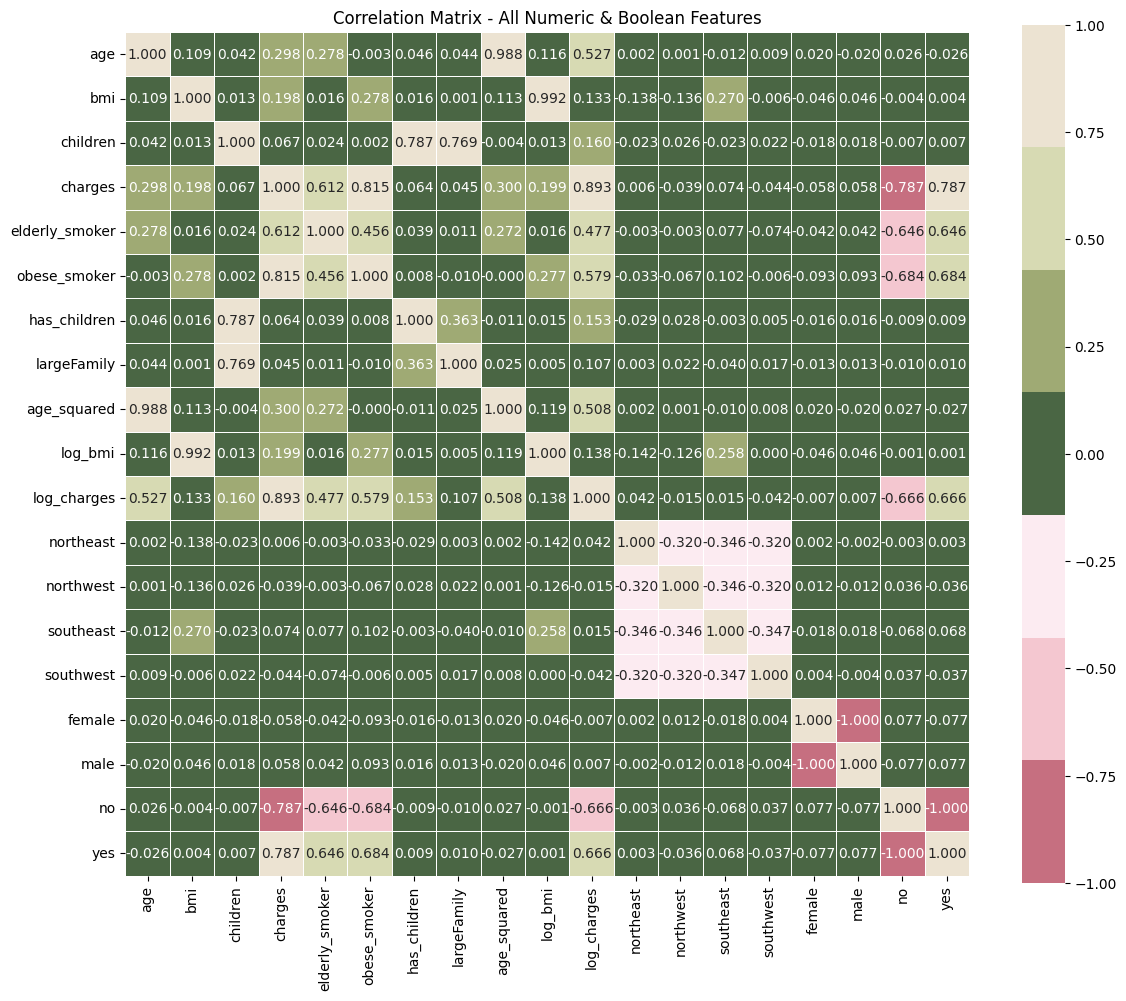


Correlations with Charges (target):
charges           1.000000
log_charges       0.893116
obese_smoker      0.815444
yes               0.787234
elderly_smoker    0.611675
age_squared       0.300166
age               0.298308
log_bmi           0.199455
bmi               0.198401
southeast         0.073578
children          0.067389
has_children      0.063985
male              0.058044
largeFamily       0.044930
northeast         0.005945
northwest        -0.038695
southwest        -0.043637
female           -0.058044
no               -0.787234
Name: charges, dtype: float64


In [46]:
# correlation matrix
correlation_matrix = data.select_dtypes(include=["number", "bool"]).corr()
plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=True, cmap=customCmap, 
            fmt='.3f', square=True, linewidths=0.5)
plt.title('Correlation Matrix - All Numeric & Boolean Features',)
plt.tight_layout()
plt.show()

print("\nCorrelations with Charges (target):")
print(correlation_matrix['charges'].sort_values(ascending=False))

strong correlation between smoking & insurance charges

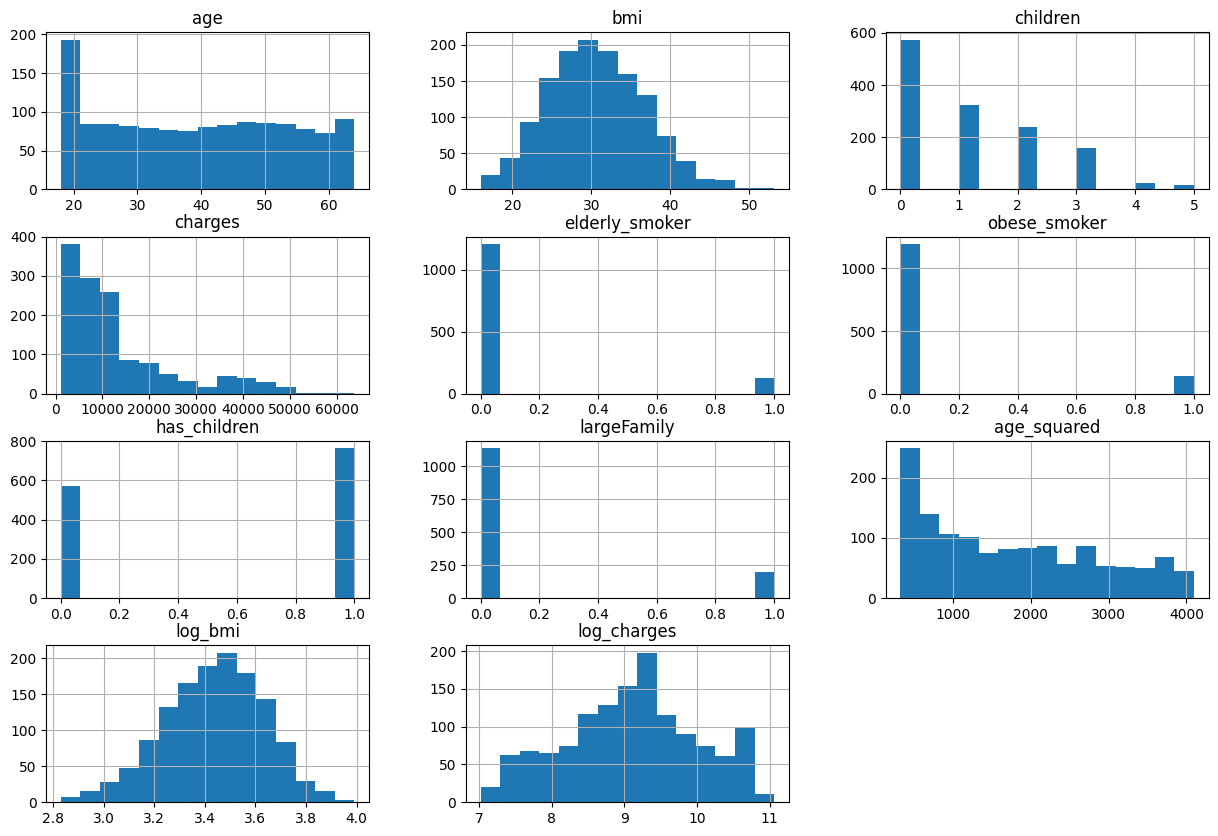

In [47]:
# histograms
histogram = data.select_dtypes(include=["number", "bool"]).hist(bins=15, figsize=[15,10])
plt.show()

<Axes: >

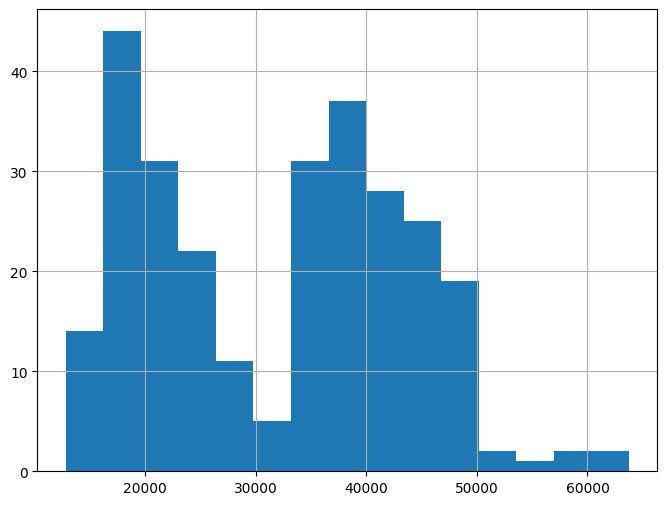

In [48]:
data[data['yes'] == True]['charges'].hist(bins=15, figsize=[8,6])


age, children, and charges are skewed to the right. bmi is reminscent of a normal curve. There is evidence of imbalance in age, children, and smoker features.

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/3444421404.py:2: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.boxplot(y='charges', x='region', hue='smoker', data=data, palette=palette)


<Axes: xlabel='region', ylabel='charges'>

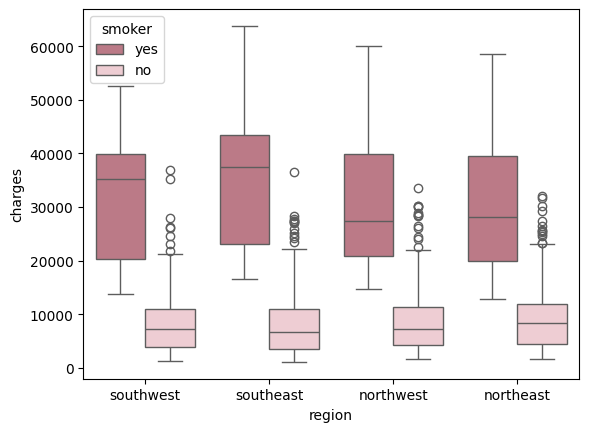

In [49]:
# due to charge feature skew, most outliers are on the higher end. 
sns.boxplot(y='charges', x='region', hue='smoker', data=data, palette=palette)

multiple experiments with boxplots; can make numerous conclusions about them. 

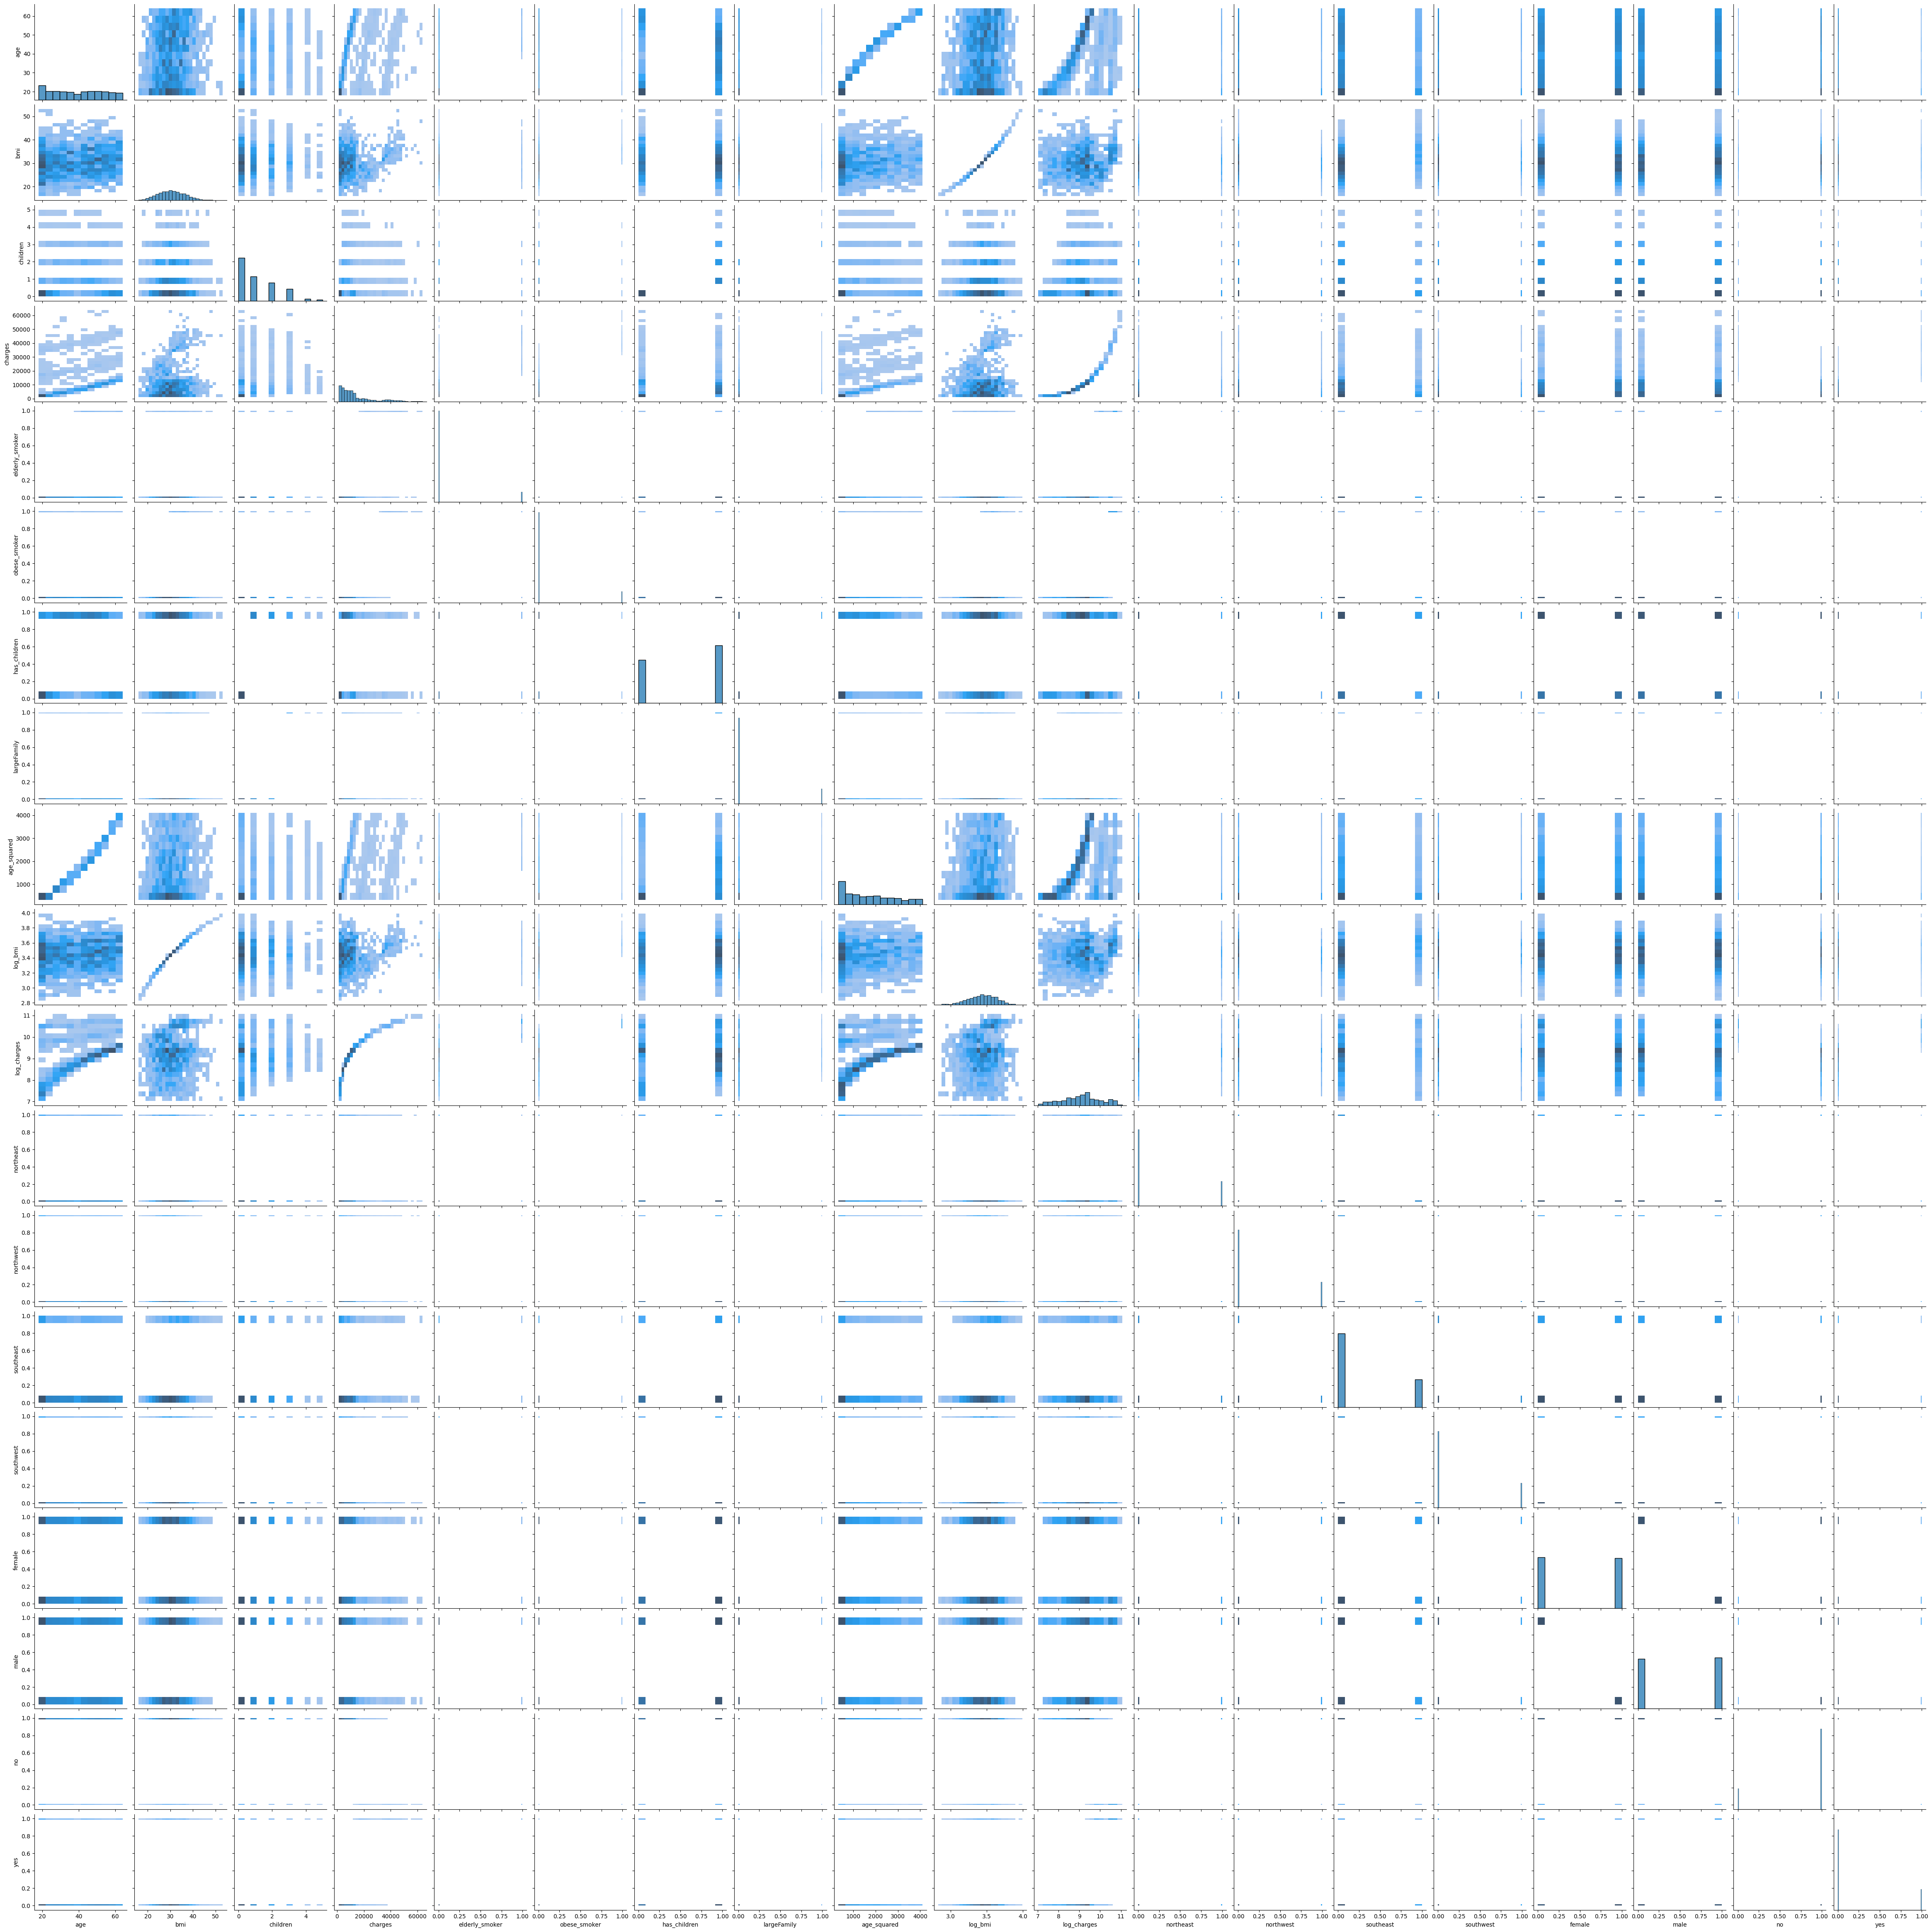

In [50]:
# pairplot video experimentation; this is so large bc of the boolean & numerical features; not super important in the grand scheme of things
sns.pairplot(data, kind='hist')

- detecting numerical features
- histograms on the diagonals; scatter plots everywhere else; can be changed
- use hue for categorical features
- boolean types are treated as numeric
- can specify which exact variables you want to see & which axis they're on 

/Users/mikayla/.venvs/insurance_ml/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/Users/mikayla/.venvs/insurance_ml/lib/python3.11/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/Users/mikayla/.venvs/insurance_ml/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)
/Users/mikayla/.venvs/insurance_ml/lib/python3.11/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(x=x, y=y, **kwargs)


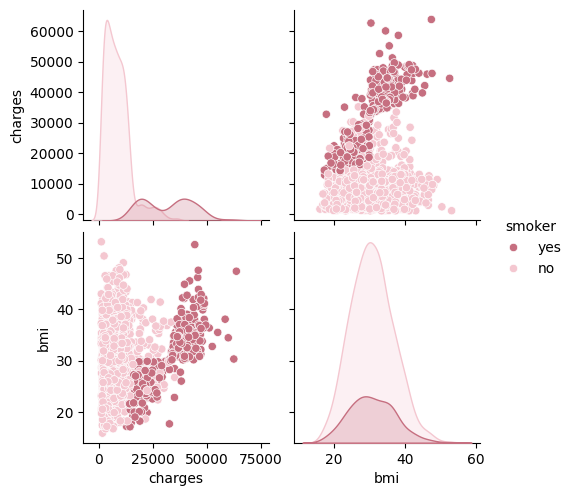

In [51]:
sns.pairplot(data, hue='smoker', palette=palette, vars=['charges', 'bmi'])

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/1108482901.py:2: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  sns.kdeplot(data, x='age', hue='smoker', palette=palette)


<Axes: xlabel='age', ylabel='Density'>

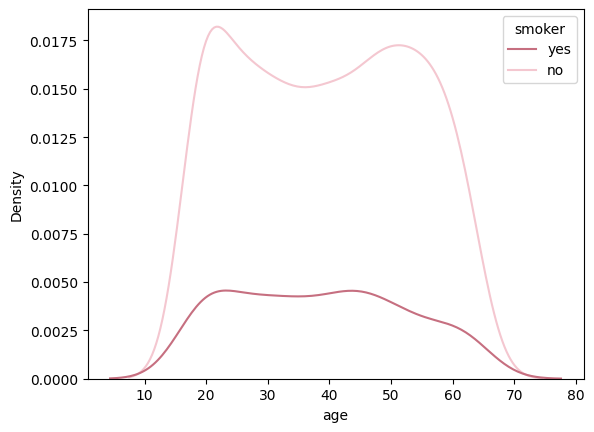

In [52]:
# to understand a misconception
sns.kdeplot(data, x='age', hue='smoker', palette=palette)

learned quite a lot from that; despite the normal-looking curve for bmi, the results showed heavy skew for overweight & obese individuals

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/1573786000.py:1: UserWarning: The palette list has more values (7) than needed (4), which may not be intended.
  sns.boxplot(y='charges', x='sex', hue='bmi_category', data=data, palette=palette)


<Axes: xlabel='sex', ylabel='charges'>

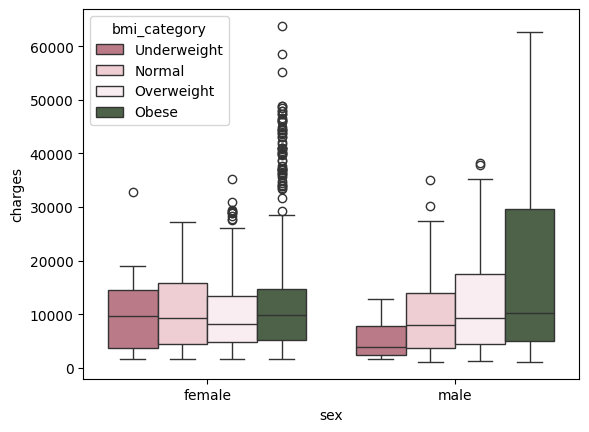

In [53]:
sns.boxplot(y='charges', x='sex', hue='bmi_category', data=data, palette=palette)

In [54]:
data.head()

,age,sex,bmi,children,smoker,region,charges,age_category,bmi_category,charges_category,...,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,19,female,27.900,0,yes,southwest,16884.92400,18-25,Overweight,"$10,001-20,000",...,3.363842,9.734236,False,False,False,True,True,False,False,True
1,18,male,33.770,1,no,southeast,1725.55230,18-25,Obese,"$0-10,000",...,3.548755,7.453882,False,False,True,False,False,True,True,False
2,28,male,33.000,3,no,southeast,4449.46200,26-35,Obese,"$0-10,000",...,3.526361,8.400763,False,False,True,False,False,True,True,False
3,33,male,22.705,0,no,northwest,21984.47061,26-35,Normal,"$20,001-30,000",...,3.165686,9.998137,False,True,False,False,False,True,True,False
4,32,male,28.880,0,no,northwest,3866.85520,26-35,Overweight,"$0-10,000",...,3.397189,8.260455,False,True,False,False,False,True,True,False


In [55]:
# let's create a contingency table to see sex & bmi broken down
crosstab01 = pd.crosstab(data['sex'], data['bmi_category'])
crosstab01

bmi_category,Underweight,Normal,Overweight,Obese
sex,,,,
female,13,118,197,334
male,8,108,189,370


<Axes: xlabel='sex'>

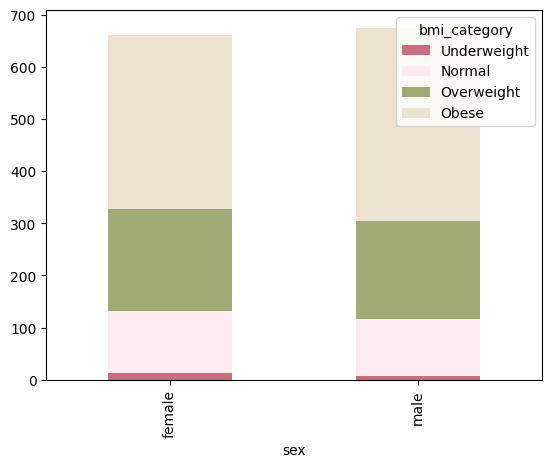

In [56]:
# visualization of above
crosstab01.plot(kind='bar', stacked = True, colormap=customCmap)

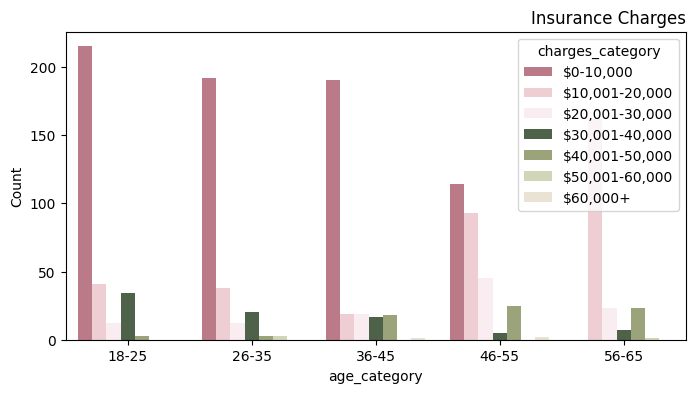

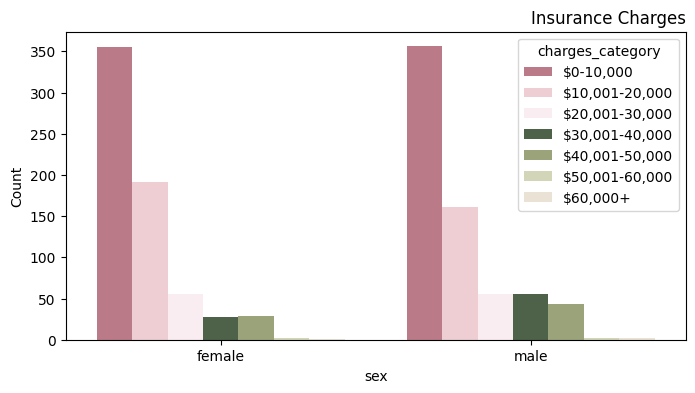

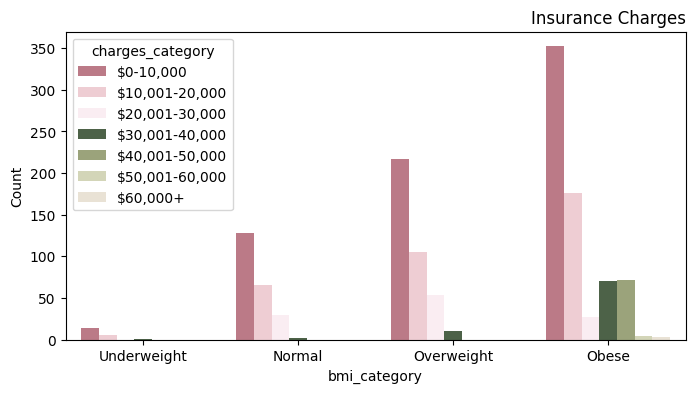

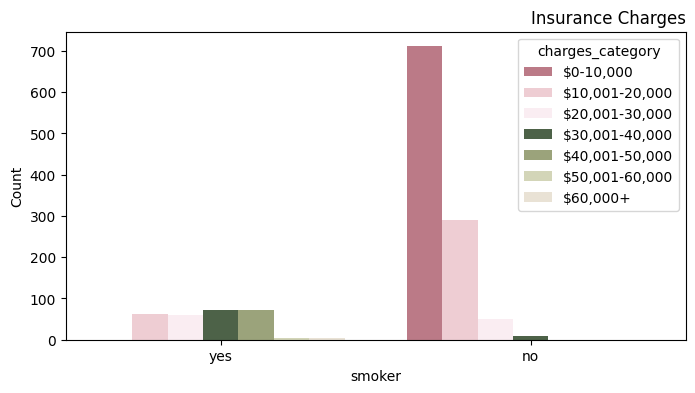

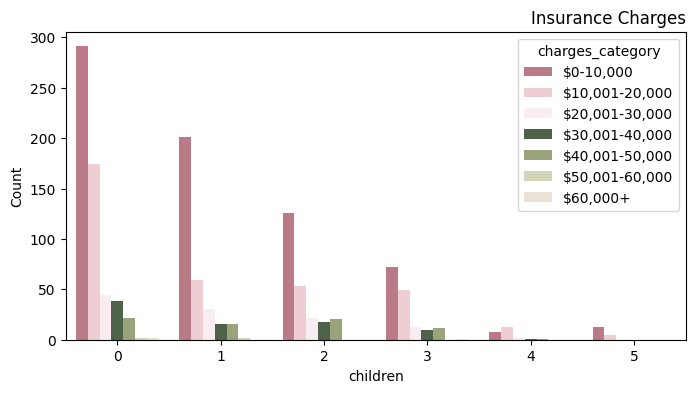

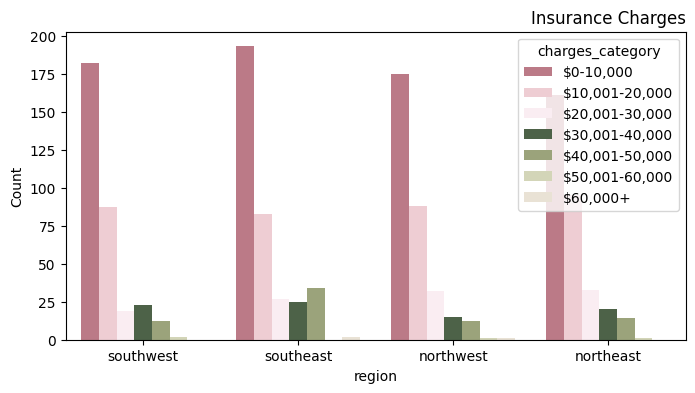

In [57]:
# checking feature importance (i think??); seeing if i can see any distinct noticeable patterns
columns = ['age_category', 'sex', 'bmi_category', 'smoker', 'children', 'region']

for col in columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, hue='charges_category', data=data, palette=palette)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title('Insurance Charges', loc='right')
    plt.show()

<Axes: xlabel='charges_category'>

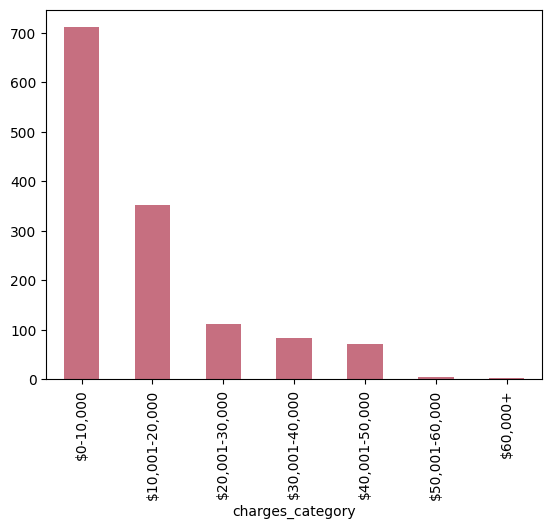

In [58]:
# interesting but knew from sql queries as well as really only helpful for visualizations & classification problems
data['charges_category'].value_counts().plot(kind='bar', colormap=customCmap)

In [59]:
# SO SKEWED
data['charges_category'].value_counts()

charges_category
$0-10,000         711
$10,001-20,000    353
$20,001-30,000    111
$30,001-40,000     83
$40,001-50,000     72
$50,001-60,000      4
$60,000+            3
Name: count, dtype: int64

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/1969443755.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = data.groupby('charges_category')[col].mean()


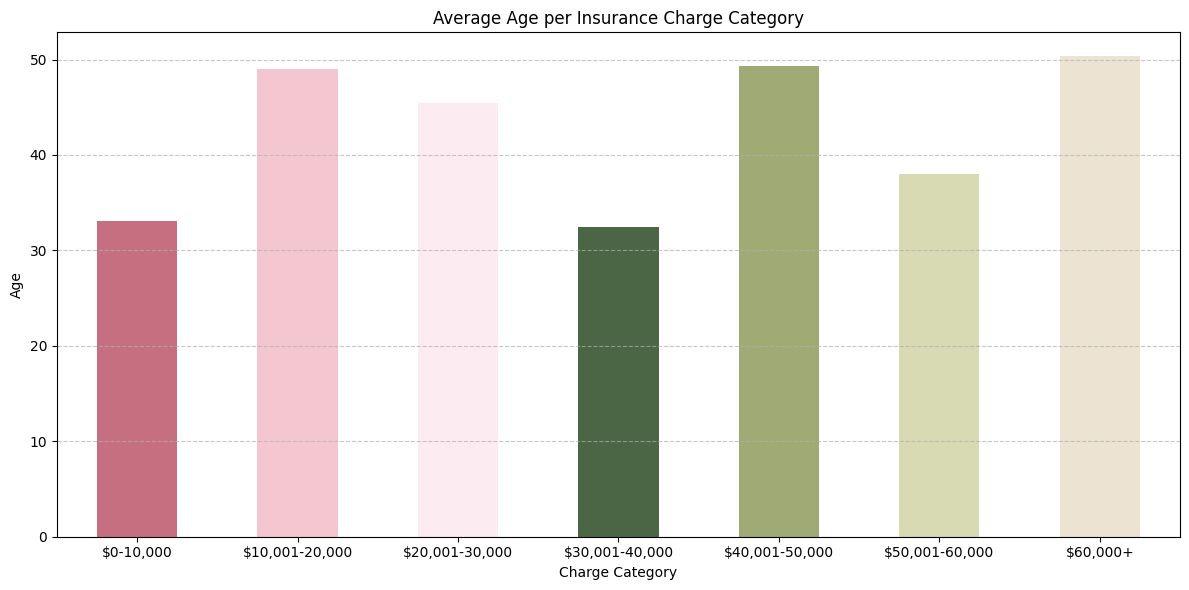

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/1969443755.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = data.groupby('charges_category')[col].mean()


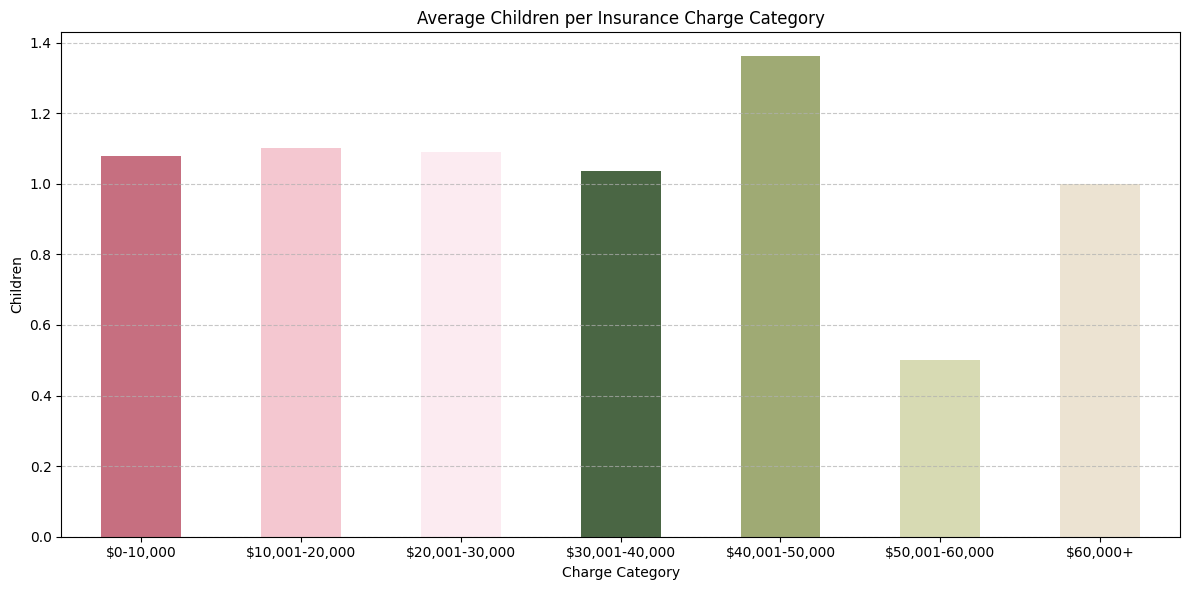

/var/folders/xg/9_zxrtsn0ll10hckyb7z5l780000gn/T/ipykernel_11811/1969443755.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = data.groupby('charges_category')[col].mean()


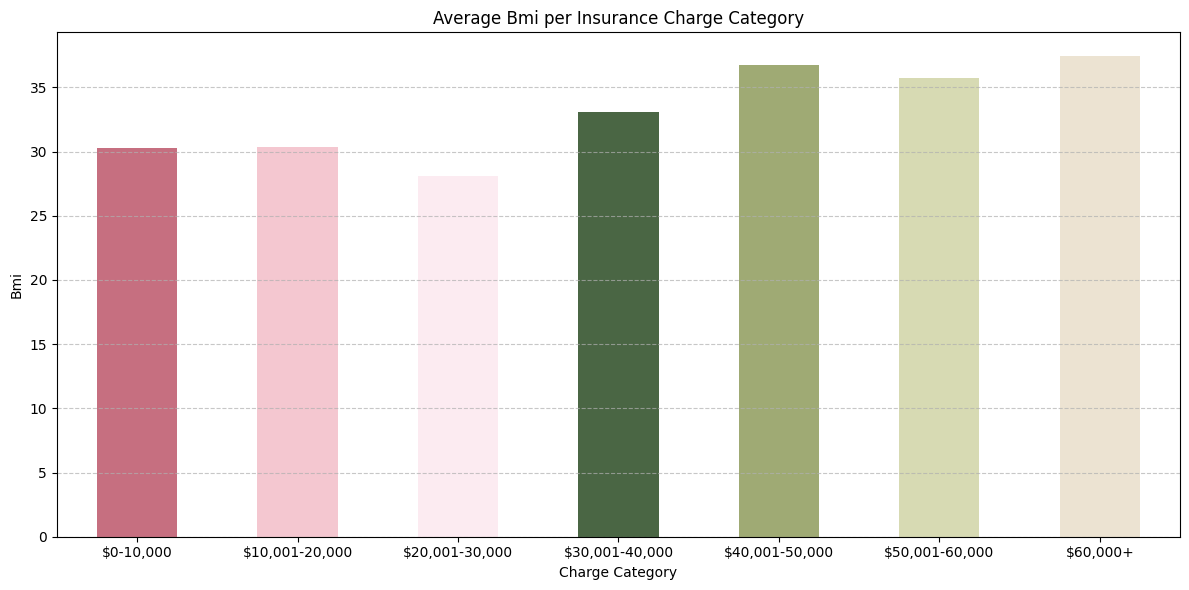

In [60]:
# finding average features for each charge category
numeric_columns = ['age', 'children', 'bmi']

for col in numeric_columns:
    mean_values = data.groupby('charges_category')[col].mean()
    plt.figure(figsize=(12, 6))
    mean_values.plot(kind='bar', color=customCmap.colors)
    plt.title(f'Average {col.capitalize()} per Insurance Charge Category')
    plt.xlabel('Charge Category')
    plt.xticks(rotation=0)
    plt.ylabel(col.capitalize())
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

MODELING

In [64]:
modeling_data = data.drop(['sex', 'smoker', 'region', 'charges_category', 'age_category', 'bmi_category', 'children', 'age', 'bmi', 'charges'], axis=1)
modeling_data.head()

,elderly_smoker,obese_smoker,has_children,largeFamily,age_squared,log_bmi,log_charges,northeast,northwest,southeast,southwest,female,male,no,yes
0,0,0,0,0,361,3.363842,9.734236,False,False,False,True,True,False,False,True
1,0,0,1,0,324,3.548755,7.453882,False,False,True,False,False,True,True,False
2,0,0,1,1,784,3.526361,8.400763,False,False,True,False,False,True,True,False
3,0,0,0,0,1089,3.165686,9.998137,False,True,False,False,False,True,True,False
4,0,0,0,0,1024,3.397189,8.260455,False,True,False,False,False,True,True,False


In [ ]:
# feature & target split
x = modeling_data.drop('log_charges')
y = modeling_data['log_charges']

# test train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)